In [77]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import anual energy production by source data
e_production_by_source = pd.read_csv('annual_e_prod_by_source.csv')

# import anual energy consumption by source data
e_consumption_by_source = pd.read_csv('annual_e_cons_by_source.csv')

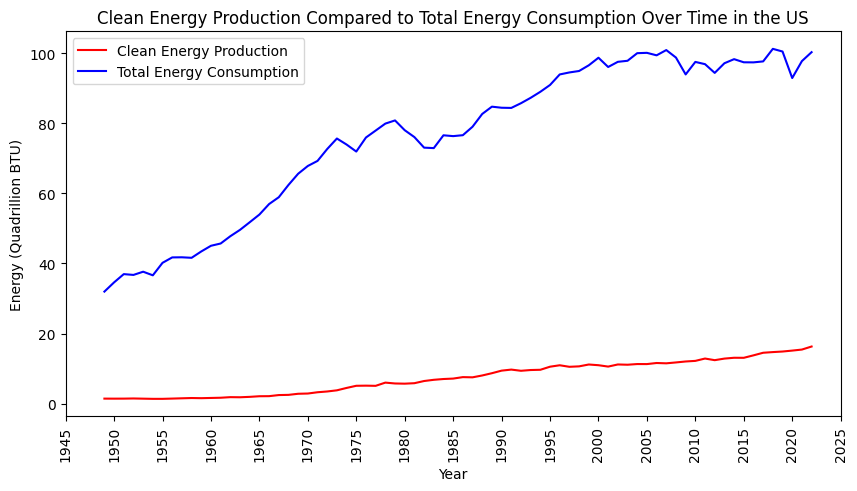

In [79]:

# Create list of energy categorized as clean energy
clean_energy = ['Nuclear', 'Solar', 'Wind', 'Hydroelectric', 'Geothermal', 'Annual Total']

cols = e_production_by_source.columns
cols_to_keep = [col if clean in col else None for clean in clean_energy for col in cols]
cols_to_keep = [col for col in cols_to_keep if col is not None]

# Create a new dataframe with only the clean energy columns
clean_energy = e_production_by_source[cols_to_keep]

# Change all Not Available to zero
clean_energy = clean_energy.replace('Not Available', 0)

# Cast all values to float
clean_energy = clean_energy.astype(float)

# Create a new column that sums all the clean energy sources
clean_energy['Total'] = clean_energy.sum(axis=1) - clean_energy['Annual Total']

# Plot the clean energy production over time
plt.figure(figsize=(10, 5))
plt.plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
plt.plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Energy (Quadrillion BTU)')
plt.legend()
plt.xlim(1945, 2025)
plt.xticks(np.arange(1945, 2026, 5), rotation=90)
plt.title('Clean Energy Production Compared to Total Energy Consumption Over Time in the US')
plt.show()


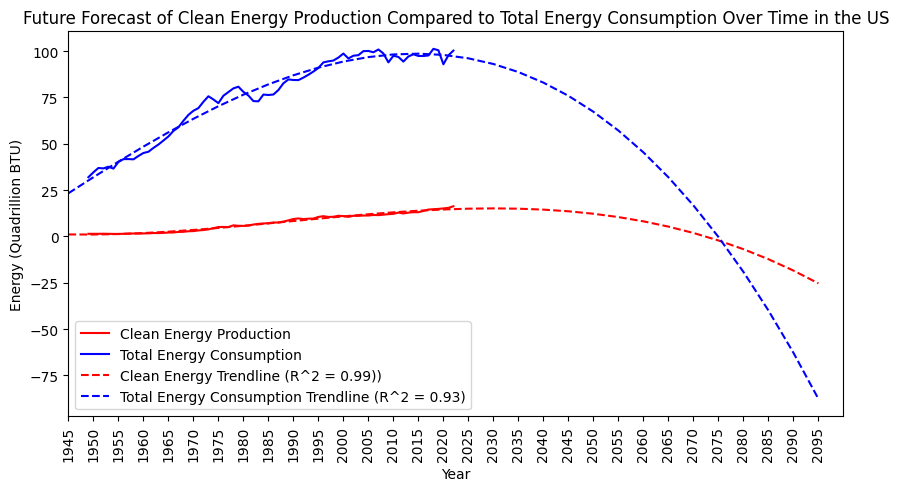

In [94]:
# Create a trendline for the clean energy data as a 3rd order polynomial and store the R^2 value
predictive_clean = np.polyfit(clean_energy['Annual Total'], clean_energy['Total'], 3)
r_squared_clean  = np.corrcoef(clean_energy['Annual Total'], np.polyval(predictive_clean, clean_energy['Annual Total']))[0, 1] ** 2

# Create a trendline for the total energy consumption data as a 3rd order polynomial and store the R^2 value
predictive_total = np.polyfit(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], 3)
r_squared_total  = np.corrcoef(e_consumption_by_source['Annual Total'], np.polyval(predictive_total, e_consumption_by_source['Annual Total']))[0, 1] ** 2

# Create a list of years to forecast trendlines out to 2050
xmin = 1945
xmax = 2100
future_years = np.arange(xmin, xmax, 5)

# Plot the trendlines
plt.figure(figsize=(10, 5))
plt.plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
plt.plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
plt.plot(future_years, np.polyval(predictive_clean, future_years), color='r', linestyle='--', label=f'Clean Energy Trendline (R^2 = {r_squared_clean:.2f}))')
plt.plot(future_years, np.polyval(predictive_total, future_years), color='b', linestyle='--', label=f'Total Energy Consumption Trendline (R^2 = {r_squared_total:.2f})')
plt.xlabel('Year')
plt.ylabel('Energy (Quadrillion BTU)')
plt.legend()
plt.xlim(xmin, xmax)
plt.xticks(np.arange(xmin, xmax, 5), rotation=90)
plt.title('Future Forecast of Clean Energy Production Compared to Total Energy Consumption Over Time in the US')
plt.show()
